<a href="https://colab.research.google.com/github/albertbolanoss/labs_deep_learning/blob/review-feature-engineering/notebooks/simpsons-image-classification/01_training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Simpsons Image Classification.

### 0. Initial Variables

In [1]:
from google.colab import auth
from googleapiclient.discovery import build

# The Google Drive Folder ID to read / write files
GOOGLE_DRIVE_FOLDER_ID = "1GZ0NBMKvCcNAvPdW50j6OwcSasaoK8A1"

# The dataset to download from Kaggle
KAGGLE_DATASET = "alexattia/the-simpsons-characters-dataset"

# The directory where the dataset is extracted
KAGGLE_UNZIP_DATASET_DIR = "/content/simpsons_data"

# Source Dataset Directory
SOURCE_DATASET = f"{KAGGLE_UNZIP_DATASET_DIR}/simpsons_dataset"

# The pre processed dataset with labels
PRE_PROCESSED_DATASET = "simpsons_pre_processed_data.npz"

# The train dataset
TRAIN_DATASET = "simpsons_train_data.npz"

# The train dataset
VAL_DATASET = "simpsons_val_data.npz"

# The test dataset
TEST_DATASET = "simpsons_test_data.npz"

# The Image Size (width,height)
IMG_WIDTH = 64
IMG_HEIGHT = 64

# Model parameters
LOG_FILENAME = f"training_log_size_{IMG_WIDTH}.csv"
CHECKPOINT_FILENAME = f"model_checkpoint_{IMG_WIDTH}.keras"
FINAL_MODEL_FILENAME = f"simpsons_model_{IMG_WIDTH}.keras"
BATCH_SIZE = 64
TOTAL_EPOCHS = 50

# Request permissions to access (read/write) the Google Drive Folder ID
auth.authenticate_user()
drive_service = build('drive', 'v3')

print(f"Successful initialization: Dataset: {KAGGLE_DATASET} - Google Drive Id: {GOOGLE_DRIVE_FOLDER_ID}")

Successful initialization: Dataset: alexattia/the-simpsons-characters-dataset - Google Drive Id: 1GZ0NBMKvCcNAvPdW50j6OwcSasaoK8A1


In [2]:
import io
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import psutil
from google.colab import auth
from googleapiclient.discovery import build
from tensorflow.keras.models import load_model as keras_load_model
from googleapiclient.http import MediaIoBaseDownload, MediaFileUpload


def save_dataset(fileName, X, y, class_names):
  np.savez_compressed(fileName, X=X, y=y, labels=class_names)

  file_metadata = {
      'name': fileName,
      'parents': [GOOGLE_DRIVE_FOLDER_ID]
  }
  media = MediaFileUpload(fileName, mimetype='application/octet-stream')

  file = drive_service.files().create(body=file_metadata, media_body=media, fields='id').execute()
  print(f"Dataset successfully '{fileName}' stored. ID in Drive: {file.get('id')}")


def load_dataset(folder_id, filename):
    query = f"name = '{filename}' and '{folder_id}' in parents and trashed = false"
    results = drive_service.files().list(q=query, fields="files(id, name)").execute()
    items = results.get('files', [])

    if not items:
        print(f"No found the file '{filename}' in the folder '{folder_id}'.")
        return None, None, None

    file_id = items[0]['id']
    request = drive_service.files().get_media(fileId=file_id)
    fh = io.BytesIO()
    downloader = MediaIoBaseDownload(fh, request)

    done = False
    while done is False:
        status, done = downloader.next_chunk()
        print(f"Download progress: {int(status.progress() * 100)}%")

    # Load NumPy data from the memory buffer
    fh.seek(0)
    data = np.load(fh, allow_pickle=True)

    X = data['X']
    y = data['y']
    labels = data['labels']

    print("Data successfully loaded.")
    return X, y, labels


def display_image(x_data, y_data, index, class_names=None):
    """
    Displays an image from the dataset with its numeric and text label.
    """
    img = x_data[index]
    label_raw = y_data[index]

    # 1. Handle One-Hot or Integer labels
    if hasattr(label_raw, '__len__') and len(label_raw) > 1:
        label_id = np.argmax(label_raw)
    else:
        label_id = int(np.array(label_raw).item())

    # 2. Setup Plot
    plt.figure(figsize=(5, 5))

    # If images were normalized (0-1 float), imshow handles it.
    # If they are 0-255 int, we ensure the type is uint8.
    if img.max() > 1.0 and img.dtype != np.uint8:
        img = img.astype(np.uint8)

    plt.imshow(img)

    # 3. Create Title (Numeric ID + Name)
    title = f"Index: {index} | Label ID: {label_id}"

    if class_names is not None:
        try:
            character_name = class_names[label_id]
            title += f"\nCharacter: {character_name.replace('_', ' ').title()}"
        except IndexError:
            title += "\n(Name not found in class_names)"

    plt.title(title)
    plt.axis('off')
    plt.show()

def show_colab_capabilities():
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)

  ram_gb = psutil.virtual_memory().total / 1e9

  if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
  else:
    print(gpu_info)

  print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

  if ram_gb < 20:
    print('Not using a high-RAM runtime')
  else:
    print('You are using a high-RAM runtime!')


def load_model_from_drive(folder_id, filename):
    """
    Searches for a model file in a specific Google Drive folder,
    downloads it locally, and loads it as a Keras model.
    """
    # 1. Search for the file in the specified Drive folder
    query = f"name = '{filename}' and '{folder_id}' in parents and trashed = false"
    results = drive_service.files().list(q=query, fields="files(id, name)").execute()
    items = results.get('files', [])

    if not items:
        print(f"Error: File '{filename}' not found in the specified Drive folder.")
        return None

    file_id = items[0]['id']
    local_path = filename  # Local path in the Colab environment

    # 2. Download the file from Google Drive
    print(f"Downloading model from Drive (ID: {file_id})...")
    request = drive_service.files().get_media(fileId=file_id)

    with io.FileIO(local_path, 'wb') as fh:
        downloader = MediaIoBaseDownload(fh, request)
        done = False
        while not done:
            status, done = downloader.next_chunk()
            if status:
                print(f"   Download Progress: {int(status.progress() * 100)}%")

    # 3. Reconstruct the Keras model object
    try:
        # We use 'keras_load_model' (the alias) to ensure we don't call this function recursively
        model = keras_load_model(local_path)
        print(f"Model '{filename}' loaded successfully.")
        return model
    except Exception as e:
        print(f"Error loading model with Keras: {e}")
        return None

def load_dataset_from_drive(folder_id, filename):
    query = f"name = '{filename}' and '{folder_id}' in parents and trashed = false"
    results = drive_service.files().list(q=query, fields="files(id, name)").execute()
    items = results.get('files', [])

    if not items:
        print(f"No found '{filename}' in Drive.")
        return None, None, None

    file_id = items[0]['id']
    request = drive_service.files().get_media(fileId=file_id)
    fh = io.BytesIO()
    downloader = MediaIoBaseDownload(fh, request)

    done = False
    while not done:
        status, done = downloader.next_chunk()
        print(f"Download dataset: {int(status.progress() * 100)}%")

    fh.seek(0)
    data = np.load(fh, allow_pickle=True)
    print("Dataset sucessful loaded.")
    return data['X'], data['y'], data['labels']

def sync_file_to_drive(local_path, drive_filename, mimetype='application/octet-stream'):
    """Sube o actualiza un archivo en Google Drive"""
    query = f"name = '{drive_filename}' and '{GOOGLE_DRIVE_FOLDER_ID}' in parents and trashed = false"
    results = drive_service.files().list(q=query, fields="files(id)").execute()
    items = results.get('files', [])

    media = MediaFileUpload(local_path, mimetype=mimetype, resumable=True)

    if items:
        file_id = items[0]['id']
        drive_service.files().update(fileId=file_id, media_body=media).execute()
        return file_id
    else:
        file_metadata = {'name': drive_filename, 'parents': [GOOGLE_DRIVE_FOLDER_ID]}
        file = drive_service.files().create(body=file_metadata, media_body=media, fields='id').execute()
        return file.get('id')

def download_file_from_drive(drive_filename, local_path):
    """Descarga un archivo de Drive a la memoria local de Colab si existe"""
    query = f"name = '{drive_filename}' and '{GOOGLE_DRIVE_FOLDER_ID}' in parents and trashed = false"
    results = drive_service.files().list(q=query, fields="files(id)").execute()
    items = results.get('files', [])

    if items:
        file_id = items[0]['id']
        request = drive_service.files().get_media(fileId=file_id)
        with io.FileIO(local_path, 'wb') as fh:
            downloader = MediaIoBaseDownload(fh, request)
            done = False
            while not done:
                _, done = downloader.next_chunk()
        return True
    return False

show_colab_capabilities()

/bin/bash: line 1: nvidia-smi: command not found
Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


### 1. Download Dataset.

In [3]:
import os
from google.colab import userdata

# Getting Kaggle credentials and setting in environment
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

# Download and unzip dataset from Kaggle
!kaggle datasets download -d {KAGGLE_DATASET}
!unzip -q the-simpsons-characters-dataset.zip -d {KAGGLE_UNZIP_DATASET_DIR}

print(f"Downloaded {KAGGLE_DATASET} in {KAGGLE_UNZIP_DATASET_DIR}")

Dataset URL: https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset
License(s): CC-BY-NC-SA-4.0
100% 1.08G/1.08G [00:03<00:00, 154MB/s]
100% 1.08G/1.08G [00:03<00:00, 363MB/s]
Downloaded alexattia/the-simpsons-characters-dataset in /content/simpsons_data


### 2. Prepare Dataset.

In [4]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def load_simpsons_dataset_with_labels(directory, img_width, img_height):
    print("Loading datasets with labels may take a while")
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))
    class_map = {name: i for i, name in enumerate(class_names)}

    # Browse folders
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        if not os.path.isdir(class_dir):
            continue

        class_idx = class_map[class_name]

        # Read images from each folder
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            try:
                # Read image with OpenCV
                img = cv2.imread(img_path)
                if img is not None:
                    # Convert BGR (OpenCV) to RGB
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    # Resize (CNN needs fixed size)
                    img = cv2.resize(img, (img_width, img_height))

                    images.append(img)
                    labels.append(class_idx)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    # Convert to numpy arrays
    X = np.array(images)
    y = np.array(labels)

    # Mix data (Shuffle)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    return X, y, class_names


X_full, y_full, class_names = load_simpsons_dataset_with_labels(SOURCE_DATASET, IMG_WIDTH, IMG_HEIGHT)
save_dataset(PRE_PROCESSED_DATASET, X_full, y_full, class_names)

print(f"# of samples: {len(X_full)}")
print(f"# of clases: {len(class_names)}: {class_names}")


Loading datasets with labels may take a while


Dataset successfully 'simpsons_pre_processed_data.npz' stored. ID in Drive: 1jnen_MUC909duaMSKZJppxYUP9UuxkIB
# of samples: 20933
# of clases: 43: ['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'simpsons_dataset', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers']


### 3. Load Pre-processed Dataset from Google Drive

In [5]:

X_full, y_full, class_names = load_dataset(GOOGLE_DRIVE_FOLDER_ID, PRE_PROCESSED_DATASET)

print(f"# of samples: {len(X_full)}")
print(f"# of clases: {len(class_names)}: {class_names}")



Download progress: 69%
Download progress: 100%
Data successfully loaded.
# of samples: 20933
# of clases: 43: ['abraham_grampa_simpson' 'agnes_skinner' 'apu_nahasapeemapetilon'
 'barney_gumble' 'bart_simpson' 'carl_carlson' 'charles_montgomery_burns'
 'chief_wiggum' 'cletus_spuckler' 'comic_book_guy' 'disco_stu'
 'edna_krabappel' 'fat_tony' 'gil' 'groundskeeper_willie' 'homer_simpson'
 'kent_brockman' 'krusty_the_clown' 'lenny_leonard' 'lionel_hutz'
 'lisa_simpson' 'maggie_simpson' 'marge_simpson' 'martin_prince'
 'mayor_quimby' 'milhouse_van_houten' 'miss_hoover' 'moe_szyslak'
 'ned_flanders' 'nelson_muntz' 'otto_mann' 'patty_bouvier'
 'principal_skinner' 'professor_john_frink' 'rainier_wolfcastle'
 'ralph_wiggum' 'selma_bouvier' 'sideshow_bob' 'sideshow_mel'
 'simpsons_dataset' 'snake_jailbird' 'troy_mcclure' 'waylon_smithers']


### Show random images

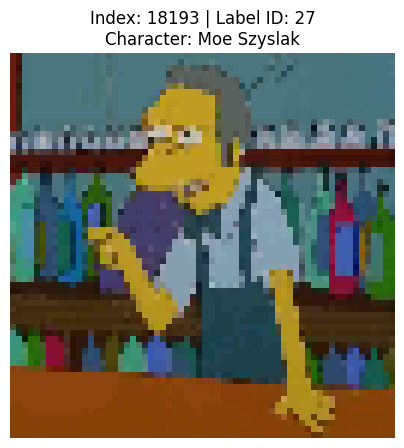

In [8]:

random_index = np.random.randint(0, len(X_full))
display_image(X_full, y_full, random_index, class_names)

### Show classes distribution

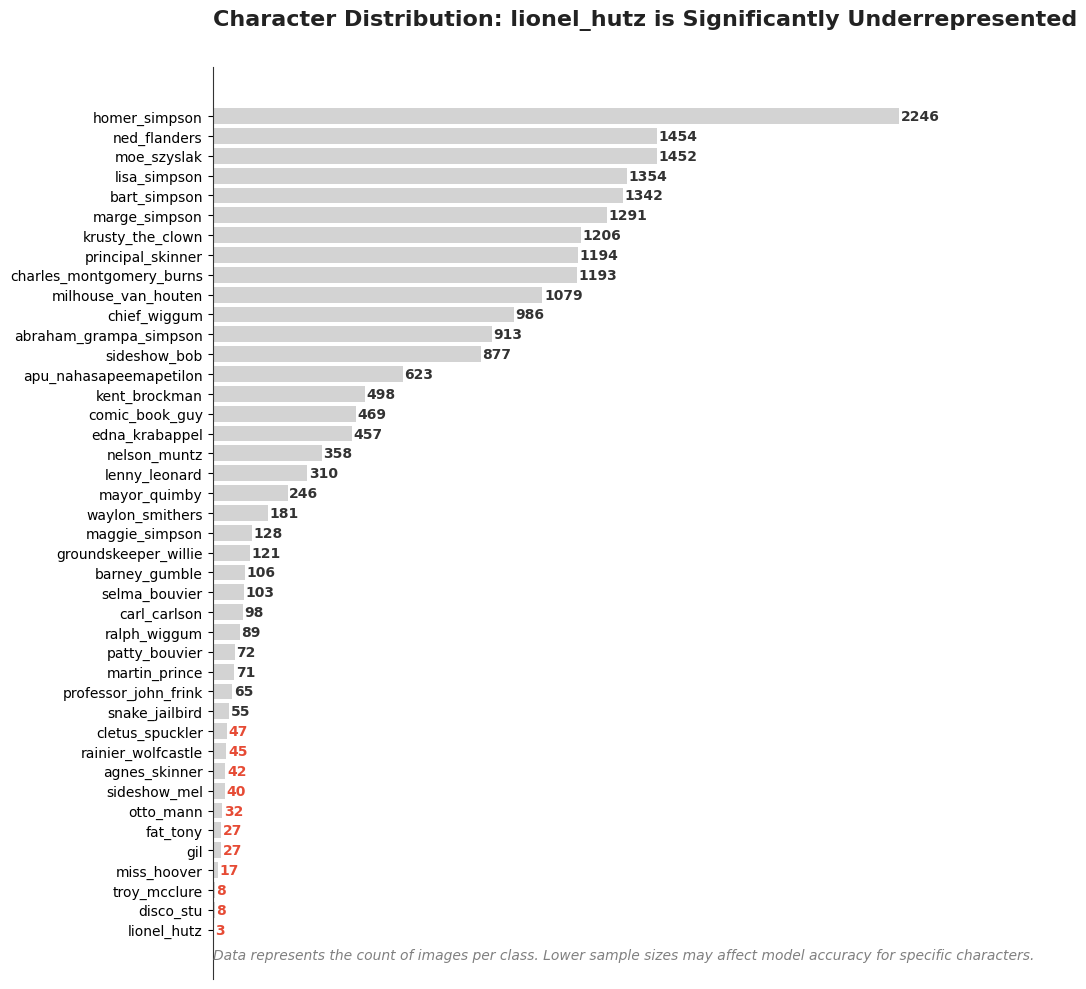

The character with low samples is: lionel_hutz


In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def show_class_distribution(y_full, class_names):
    # 1. Data Preparation
    unique, counts = np.unique(y_full, return_counts=True)
    df_counts = pd.DataFrame({
        'Character': [class_names[i] for i in unique],
        'Count': counts
    }).sort_values(by='Count', ascending=True) # Ascending for a better horizontal look

    # 2. Setup colors - Highlight the character with low samples
    # Based on your print: class_names[19] is the one to watch
    target_char = class_names[19]
    colors = ['#d3d3d3' if char != target_char else '#E64B35' for char in df_counts['Character']]

    # 3. Create the plot
    fig, ax = plt.subplots(figsize=(10, 10))
    bars = ax.barh(df_counts['Character'], df_counts['Count'], color=colors)

    # 4. Decluttering (Removing Spines)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_color('#333333')

    # 5. Remove X-axis labels (Direct labeling is enough)
    ax.set_xticks([])

    # 6. Add direct labels at the end of bars
    for bar in bars:
        width = bar.get_width()
        label_color = '#333333' if width > 50 else '#E64B35'
        ax.text(width + 5, bar.get_y() + bar.get_height()/2,
                f'{int(width)}',
                va='center', fontsize=10, color=label_color, fontweight='bold')

    # 7. Strategic Titles and Alignment
    plt.title(f'Character Distribution: {target_char} is Significantly Underrepresented',
              fontsize=16, pad=30, loc='left', color='#222222', fontweight='bold')

    # Text annotation for context
    plt.text(0, -1.5, "Data represents the count of images per class. Lower sample sizes may affect model accuracy for specific characters.",
             fontsize=10, color='gray', style='italic')

    plt.tight_layout()
    plt.show()

# Execution
show_class_distribution(y_full, class_names)
print(f"The character with low samples is: {class_names[19]}")

### 4. Feature Engineering

In [40]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# ==========================================
# 1. DATA PREPARATION & NORMALIZATION
# ==========================================

# NOTE: Ensure X_full is reloaded before running this cell to reset state
X_full, y_full, class_names = load_dataset(GOOGLE_DRIVE_FOLDER_ID, PRE_PROCESSED_DATASET)

print(f"1. Normalize: Original shapes -> X: {X_full.shape}, y: {y_full.shape}")

# Normalize pixel values to range [0, 1]
X_full = X_full.astype('float32') / 255.0

# ==========================================
# 2. FILTER RARE CLASSES (Data Cleaning)
# ==========================================
MIN_SAMPLES_THRESHOLD = 5

# Identify unique classes and their frequencies
unique_classes, counts = np.unique(y_full, return_counts=True)
rare_classes_ids = unique_classes[counts < MIN_SAMPLES_THRESHOLD]

print(f"2. Filter rare classes: Classes to drop (ID < {MIN_SAMPLES_THRESHOLD} samples): {rare_classes_ids}")

if len(rare_classes_ids) > 0:
    # Find indices of all samples belonging to rare classes
    indices_to_remove = np.where(np.isin(y_full, rare_classes_ids))[0]

    # Remove samples from X and y (axis=0 prevents flattening)
    X_filtered = np.delete(X_full, indices_to_remove, axis=0)
    y_filtered = np.delete(y_full, indices_to_remove, axis=0)

    # Update class names list (removing names of dropped classes)
    rare_classes_set = set(rare_classes_ids)
    class_names_filtered = [name for i, name in enumerate(class_names) if i not in rare_classes_set]

    assert len(X_filtered) == len(y_filtered), "Mismatch between X and y lengths after filtering!"
    print(f"Filtered shapes -> X: {X_filtered.shape}, y: {y_filtered.shape}")
else:
    X_filtered, y_filtered, class_names_filtered = X_full, y_full, class_names
    print("No classes below threshold found. No data removed.")

# ==========================================
# 3. LABEL ENCODING
# ==========================================
# Re-encode labels to ensure they are continuous (0, 1, 2...)
le = LabelEncoder()
y_encoded = le.fit_transform(y_filtered)

# The 'le' fits based on the sorted values of y_filtered.
# Since 'class_names_filtered' kept the original order, they align with the new codes 0,1,2...
final_class_names = le.classes_
print(f"Total classes remaining: {len(final_class_names)}")

# ==========================================
# 4. DATA SPLITTING (Train / Val / Test)
# ==========================================

# First Split: 80% Train, 20% Temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X_filtered,
    y_encoded,
    test_size=0.20,
    random_state=42,
    stratify=y_encoded
)

# Second Split: 10% Val, 10% Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

# ==========================================
# 5. VERIFICATION OF SPLIT
# ==========================================
print("-" * 30)
print(f"Training set:   {X_train.shape} samples")
print(f"Validation set: {X_val.shape} samples")
print(f"Test set:       {X_test.shape} samples")
print("-" * 30)

# ==========================================
# 6. RETRIEVE CLASS NAMES (Decoding) -> NEW CODE
# ==========================================

# Convert the list of strings to a NumPy array for vectorized indexing
names_array = np.array(class_names_filtered)

# Use the encoded labels (y_train, etc.) as indices to get the names
# e.g., if y_train[0] is 5, it grabs the name at index 5 of names_array
train_class_names = names_array[y_train]
val_class_names   = names_array[y_val]
test_class_names  = names_array[y_test]

# Final Check
print(f"Success! Names extracted.")
print(f"Example from Test Set:")
print(f"   Encoded ID: {y_test[0]}")
print(f"   Class Name: {test_class_names[0]}")

# Save datasets
save_dataset(TRAIN_DATASET, X_train, y_train, class_names)
save_dataset(VAL_DATASET, X_val, y_val, class_names)
save_dataset(TEST_DATASET, X_test, y_test, class_names)

Download progress: 69%
Download progress: 100%
Data successfully loaded.
1. Normalize: Original shapes -> X: (20933, 64, 64, 3), y: (20933,)
2. Filter rare classes: Classes to drop (ID < 5 samples): [19]
Filtered shapes -> X: (20930, 64, 64, 3), y: (20930,)
Total classes remaining: 41
------------------------------
Training set:   (16744, 64, 64, 3) samples
Validation set: (2093, 64, 64, 3) samples
Test set:       (2093, 64, 64, 3) samples
------------------------------
Success! Names extracted.
Example from Test Set:
   Encoded ID: 17
   Class Name: krusty_the_clown
Dataset successfully 'simpsons_train_data.npz' stored. ID in Drive: 1IRxtzb8idFMm2AwfFVUVF5Hv-Zpdq9eI
Dataset successfully 'simpsons_val_data.npz' stored. ID in Drive: 11uqaZXMJk7GUegjxqXfftvBwuNiQHL7j
Dataset successfully 'simpsons_test_data.npz' stored. ID in Drive: 1dcb724f9hmQ3r0SeiXDDbvooRScuEiXV


In [ ]:
X_train, y_train, classNames = load_dataset(GOOGLE_DRIVE_FOLDER_ID, TRAIN_DATASET)
X_val, y_val, classNames = load_dataset(GOOGLE_DRIVE_FOLDER_ID, VAL_DATASET)
X_test, y_test, classNames = load_dataset(GOOGLE_DRIVE_FOLDER_ID, TEST_DATASET)

Download progress: 57%
Download progress: 100%
Data successfully loaded.
Download progress: 100%
Data successfully loaded.
Download progress: 100%
Data successfully loaded.


### 5. Training

Pixels do NOT influence the number of parameters of a Conv2D layer.

### Block 1:

#### Convolution.

Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))


- Number of filters: 32
- Filter size: 3 x 3
- Image chanels: 3
- Parameters or weights: 3 x 3 (Filter size) x 3 (Image chanels) + 1 (bias)  x 32 (Number of filters) = 896
- Los píxeles NO influyen en el número de parámetros de una capa Conv2D.

#### BatchNormalization (BN):

Imagine that after a convolution, some of your pixel values ​​are huge (e.g., 250) and others are minuscule (e.g., 0.01). If this continues, the network becomes unstable and difficult to train (this is what we call Internal Covariate Shift).

- Normalize: It takes the data and adjusts it so that it has a mean of 0 and a standard deviation of 1.
- Scale and Shift: Since the network might not want everything to have a mean of 0, the BN gives the network two adjustable "knobs" so it can decide how to move that data.

For each channel (or filter) that enters the BN layer, the network needs to learn 4 parameters.

- $\gamma$ (Gamma): A scale factor (weights).
- $\beta$ (Beta): A bias factor.
- $\mu$ (Media móvil): The average of the data that is being passed.
- $\sigma^2$ (Varianza móvil): Data dispersion.

$$\text{total parameters} = 4 \times \text{Number of filters}$$

#### Consecutive Convolutions (The VGG Strategy)

In the provided architecture, Block 1 uses two consecutive `Conv2D(32, (3,3))` layers. This is a common practice in deep learning for several technical reasons.

**1. Receptive Field Comparison**
* **Layer 1 (3x3):** Focuses on small, local features (edges, dots).
* **Layer 2 (3x3):** Processes the output of Layer 1, effectively "seeing" a **5x5** area of the original image.

**2. Efficiency Gains**
* **Weights in one 5x5 filter:** 25
* **Weights in two 3x3 filters:** 9 + 9 = 18
* **Benefit:** Same spatial coverage with **28% fewer parameters**.

**3. Depth and Non-Linearity**
By using two layers instead of one, we apply the **ReLU** activation function twice. This allows the model to learn more complex decision boundaries.

#### MaxPooling2D((2, 2))

MaxPooling acts as a **"summarizer."** It slides a window (usually 2x2) over the feature map and keeps only the maximum value from that window, discarding the rest.

* **Spatial Reduction:** It effectively shrinks the width and height of the image by half. A $100 \times 100$ input becomes $50 \times 50$.
* **Feature Invariance:** It helps the model recognize a pattern even if it is shifted slightly in the image.

**Parameter Impact**
* **Parameters:** **0**. It is a fixed mathematical operation (selecting the maximum). There are no weights to learn.
* **Effect on Model:** It **indirectly reduces** parameters by shrinking the data passed to the next layer. This is crucial to prevent the final `Dense` layers from becoming too massive.

#### Dropout(0.2)

Dropout is a **regularization technique** used to prevent "overfitting" (when the model memorizes the training data but fails with new images).

* **The Logic:** During training, it randomly "turns off" a percentage of neurons (in your case, 20%) in every pass.
* **Robustness:** This forces the network to find multiple paths to solve the problem, ensuring that it doesn't rely too heavily on a single "master" neuron.

**Parameter Impact**
* **Parameters:** **0**. It doesn't add or remove connections permanently; it just temporarily ignores them during training.
* **Effect on Model:** It has **no effect** on the parameter count, but it significantly improves the **generalization** of the model.

#### Analysis: The Classifier (Layer 4)

After extracting features with Convolutions, the network needs to classify them. This is the role of the **Dense** (Fully Connected) layers.

**1. Flatten()**

* **Role:** The bridge between the 3D world of Convolutions and the 1D world of Dense layers.
* **Math:** If the input is $(H, W, C)$, the output is $H \times W \times C$.
* **Parameters:** 0.

**2. Dense(512)**

* **Role:** High-level reasoning. It looks at the "unrolled" features and decides which combinations represent specific objects.
* **Cost:** Very high. Most of the model's memory footprint is usually located here.

**3. Softmax Output**

* **Role:** The final verdict.
* **Logic:** It produces a probability for each class.
* **Formula:** $$\sigma(z)_i = \frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}}$$
  *(This ensures all outputs sum to 1.0)*

In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, Callback
from googleapiclient.http import MediaFileUpload, MediaIoBaseDownload

X_train, y_train, classNames = load_dataset(GOOGLE_DRIVE_FOLDER_ID, TRAIN_DATASET)
X_val, y_val, classNames = load_dataset(GOOGLE_DRIVE_FOLDER_ID, VAL_DATASET)

# Customized Callback to upload the log to Drive after each season
class DriveSyncCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        sync_file_to_drive(LOG_FILENAME, LOG_FILENAME, mimetype='text/csv')
        # Opcional: sincronizar también el checkpoint para no perder progreso
        if os.path.exists(CHECKPOINT_FILENAME):
            sync_file_to_drive(CHECKPOINT_FILENAME, CHECKPOINT_FILENAME)
        print(f"\n Progress synchronized with Google Drive.")


initial_epoch = 0
if download_file_from_drive(LOG_FILENAME, LOG_FILENAME):
    try:
        history_df = pd.read_csv(LOG_FILENAME)
        if not history_df.empty:
            initial_epoch = int(history_df['epoch'].max() + 1)
            print(f"Resuming from epoch {initial_epoch}")
            # Attempt to download previous weights
            download_file_from_drive(CHECKPOINT_FILENAME, CHECKPOINT_FILENAME)
    except Exception as e:
        print(f"Error processing logs: {e}")

# Model Architecture
model = Sequential([
    # Layer 1
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    # Layer 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Layer 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    # Layer 4
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Load weights if we resume
if initial_epoch > 0 and os.path.exists(CHECKPOINT_FILENAME):
    try:
        model.load_weights(CHECKPOINT_FILENAME)
        print("Weights loaded correctly.")
    except:
        print("No weights could be loaded. Starting from scratch.")
        initial_epoch = 0

# Image Data Generator definition
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, zoom_range=0.1)

callbacks = [
    ModelCheckpoint(CHECKPOINT_FILENAME, save_best_only=False),
    CSVLogger(LOG_FILENAME, append=True),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    DriveSyncCallback() # Synchronize log and checkpoint to Drive for each epoch
]

if initial_epoch < TOTAL_EPOCHS:
    model.fit(
        datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
        epochs=TOTAL_EPOCHS,
        initial_epoch=initial_epoch,
        validation_data=(X_val, y_val), # Cambiar por x_valid si lo tienes separado
        callbacks=callbacks
    )

    # Saving final model
    model.save(FINAL_MODEL_FILENAME)
    sync_file_to_drive(FINAL_MODEL_FILENAME, FINAL_MODEL_FILENAME, mimetype='application/x-keras')
    print(f"Training completed and final model saved ({FINAL_MODEL_FILENAME}) to Drive.")

Download progress: 57%
Download progress: 100%
Data successfully loaded.
Download progress: 100%
Data successfully loaded.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.2409 - loss: 3.4680
 Progress synchronized with Google Drive.
262/262 ━━━━━━━━━━━━━━━━━━━━ 47s 127ms/step - accuracy: 0.2412 - loss: 3.4658 - val_accuracy: 0.0511 - val_loss: 4.0327
Epoch 2/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4803 - loss: 2.0063
 Progress synchronized with Google Drive.
262/262 ━━━━━━━━━━━━━━━━━━━━ 23s 89ms/step - accuracy: 0.4804 - loss: 2.0058 - val_accuracy: 0.4845 - val_loss: 1.7926
Epoch 3/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6110 - loss: 1.4365
 Progress synchronized with Google Drive.
262/262 ━━━━━━━━━━━━━━━━━━━━ 23s 87ms/step - accuracy: 0.6111 - loss: 1.4362 - val_accuracy: 0.7238 - val_loss: 1.0655
Epoch 4/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6960 - loss: 1.1204
 Progress synchronized with Google Drive.
262/262 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.6960 - loss: 1.1203 - val_accuracy: 0.7224 - val_loss: 1.0279
Epoch 5/50
262/262

### Evaluate Model

In [ ]:
# 3. Evaluación formal
model = load_model_from_drive(GOOGLE_DRIVE_FOLDER_ID, FINAL_MODEL_FILENAME)
X_test, y_test, classNames = load_dataset(GOOGLE_DRIVE_FOLDER_ID, TEST_DATASET)

results = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]*100:.2f}%")

   Download Progress: 100%
Model 'simpsons_model_64.keras' loaded successfully.
Download progress: 100%
Data successfully loaded.
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9163 - loss: 0.3512
Test Loss: 0.3230
Test Accuracy: 92.02%
